# Road Segment Classification

***

### Overview
One of the neighborhood disorder criteria the team is studying is road conditions, which can provide a general indication of:
* Neglect: Poor road conditions, such as potholes, cracks, and uneven surfaces, can signal a lack of investment and maintenance in a neighborhood. This can lead to a perception of neglect and disinvestment, which can contribute to a sense of disorder and decline.
* Safety: Deteriorated roads can pose safety hazards for drivers, cyclists, and pedestrians. Potholes can cause vehicle damage, while uneven surfaces can increase the risk of accidents. These safety concerns can contribute to a feeling of unease and disorder in the neighborhood.
* Quality of Life: Poor road conditions can negatively impact residents' quality of life. They can make commutes longer and more uncomfortable, increase vehicle wear and tear, and hinder access for emergency vehicles. These inconveniences and disruptions can contribute to a sense of frustration and disorder.
* Etc.

Gaining a sense of road condition per neighborhood can provide useful information to researchers studying disorder and it's relation to various outcomes. This notebook aims to automate the classification of road condition through the use of computer vision on google street view image data.


### Core Methodology
* Load Data & Segment Roads:
  * Load Google Street View (GSV) image data from roboflow (which includes bounding box annotations of potholes, major cracks, and other road deformities)
  * Import Road Segmentation Model (SegFormer) pretrained on Cityscapes dataset
  * Develop road mask passing GSV images through SegFormer which can segment out road from background (blackout background)
  * Save masked images to folder
* Damage Ratio Calculation
  * Masked GSV images appear as the original image size with background blacked out and road segment visible
  * Calculate total road area in image by adding non-black pixels
  * Calculate damage road area in image by adding bounding box pixels
  * Calculate "damage ratio" by taking the damaged road area divided by the total road area; This gives is the relative amount of "bad road" in given GSV image
  * Save damage ratio data to CSV
* Modeling & Validation:
  * Separate images in a binary class using a damage threshold = 0.25 (Note: this threshold is subjective, but it's primary use is to deter a model from classifing a "mostly" good road as bad simply due to an small annotation)
  * Damage Ratio <= 0.25 [*Good Road*]
  * Damage Ratio > 0.25 [*Bad Road*]
  * Leverage a pre-trained ResNet(18, 50, or 101; pretrained on ImageNet images) and fine tune on segmented and class defined images *Note: Ultimately used ResNet101*
  * Visualize results via confusion matrix and natural KPIs such as Precision and Recall
* Visual Auditing:
  * Visualize samples from confusion matrix
  * Visualize via GradCAM (Class Avtivation Map)


***
### Data Load & Preprocessing


In [ ]:
!pip install roboflow
!pip install ultralytics
!pip install transformers accelerate  # accelerate helps speed things up on GPU

  Using cached ultralytics-8.3.80-py3-none-any.whl.metadata (35 kB)
  Using cached ultralytics_thop-2.0.14-py3-none-any.whl.metadata (9.4 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.3.1.170-py3-none-manylinux2014_x86_64.whl.m

In [ ]:
### NEW MVP2 BAD ROAD DATASET
from roboflow import Roboflow
#from roboflow import Roboflow
rf = Roboflow(api_key="NFaT5T98SfSS3amzAhaW")
project = rf.workspace("d4cg").project("mvp2-fyhaf")
version = project.version(1)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to MVP2-1 in yolov11:: 100%|██████████| 4018/4018 [00:00<00:00, 6525.03it/s]


In [ ]:
import os
import glob

subsets = ["train", "valid", "test"]
for subset in subsets:
    image_dir = os.path.join("MVP2-1", subset, "images")
    img_paths = glob.glob(os.path.join(image_dir, '*.jpg'))

    print(f"Searching for .jpg in {image_dir}: found {len(img_paths)} images")
    if len(img_paths) > 0:
        print("Sample:", img_paths[:5])  # see first 5

Searching for .jpg in MVP2-1/train/images: found 1494 images
Sample: ['MVP2-1/train/images/image_8118_W_Garfield_Park_jpg.rf.d07fdaa6c863414492f7c385bc31bc11.jpg', 'MVP2-1/train/images/image_4465_East_Garfield_Park_Interior_jpg.rf.21a80ef3fa1eaf0440418fca5d76ea4c.jpg', 'MVP2-1/train/images/image_3837_W_Garfield_Park_jpg.rf.6d0e86976d8b50c5878eb2ee6b5f5495.jpg', 'MVP2-1/train/images/image_6657_East_Garfield_Park_Interior_jpg.rf.60d2c0c493907f3d125b182d67b8f336.jpg', 'MVP2-1/train/images/image_7208_East_Garfield_Park_Interior_jpg.rf.a5e8808152d2129c1c2dee561cedaee7.jpg']
Searching for .jpg in MVP2-1/valid/images: found 254 images
Sample: ['MVP2-1/valid/images/image_129_W_Garfield_Park_jpg.rf.18039ad17662b59b76ed10bf4589b28c.jpg', 'MVP2-1/valid/images/image_8010_W_Garfield_Park_jpg.rf.fcd7c82e667c8120c2f6d9b518940fca.jpg', 'MVP2-1/valid/images/image_3794_W_Garfield_Park_jpg.rf.92325b87a1ef12d309154cda7be5b0a3.jpg', 'MVP2-1/valid/images/image_8450_W_Garfield_Park_jpg.rf.d5cd449ec9ac67382f0

In [ ]:
import glob
import shutil
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
import cv2
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation

In [ ]:
# Verify GPU:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [ ]:
# 1) Initialize segmentation model
model_name = "nvidia/segformer-b5-finetuned-cityscapes-1024-1024"
processor = AutoImageProcessor.from_pretrained(model_name)
model = SegformerForSemanticSegmentation.from_pretrained(model_name).to(device)
model.eval()

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

In [ ]:
# 2) Define original (unmasked) dataset directory
unmasked_dataset_dir = "MVP2-1"

# 3) Define an output directory for the new "masked" dataset
masked_dataset_dir = "MVP2-1_Masked"
os.makedirs(masked_dataset_dir, exist_ok=True)

# 4) Subfolders we expect: train, valid, test (or val)
subsets = ["train", "valid", "test"]

# Make parallel folder structure
for subset in subsets:
    os.makedirs(os.path.join(masked_dataset_dir, subset, "images"), exist_ok=True)
    os.makedirs(os.path.join(masked_dataset_dir, subset, "labels"), exist_ok=True)

In [ ]:
# 5) Iterate over each subset (train, valid, test)
total_count = 0
for subset in subsets:
    image_dir = os.path.join(unmasked_dataset_dir, subset, "images")
    label_dir = os.path.join(unmasked_dataset_dir, subset, "labels")

    masked_image_dir = os.path.join(masked_dataset_dir, subset, "images")
    masked_label_dir = os.path.join(masked_dataset_dir, subset, "labels")

    # Grab all .jpg images (adjust if you have .png, etc.)
    img_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))

    print(f"{subset} has {len(img_paths)} images found in '{image_dir}'")
    total_count += len(img_paths)

    for img_path in img_paths:
        # Read image with PIL
        img_pil = Image.open(img_path).convert("RGB")
        width, height = img_pil.size

        # Convert to model inputs
        inputs = processor(img_pil, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits  # shape [1, num_classes, h, w]

        # Resize logits to match original (height, width)
        logits = F.interpolate(logits, size=(height, width),
                               mode="bilinear", align_corners=False)

        # Argmax along 'num_classes' dimension -> predicted class per pixel
        seg = logits.argmax(dim=1)[0].cpu().numpy()

        # Assuming 'road' = 0, create a binary mask
        road_mask = (seg == 0).astype(np.uint8)

        # Convert PIL -> NumPy (RGB)
        img_np = np.array(img_pil)  # shape (H, W, 3)
        masked_img_np = img_np.copy()
        masked_img_np[road_mask == 0] = [0, 0, 0]  # black out non-road

        # Save masked image as .jpg in new directory
        # OpenCV expects BGR, so convert if you want to use cv2.imwrite
        masked_img_bgr = cv2.cvtColor(masked_img_np, cv2.COLOR_RGB2BGR)
        out_img_path = os.path.join(masked_image_dir, os.path.basename(img_path))
        cv2.imwrite(out_img_path, masked_img_bgr)

        # Copy the corresponding YOLO label file
        #   If your label is "same_basename.txt"
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(label_dir, base_name + ".txt")
        if os.path.exists(label_path):
            shutil.copy(label_path, os.path.join(masked_label_dir, base_name + ".txt"))

train has 1494 images found in 'MVP2-1/train/images'
valid has 254 images found in 'MVP2-1/valid/images'
test has 255 images found in 'MVP2-1/test/images'


In [ ]:
# Save masked images for later

from google.colab import drive
import shutil

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
masked_dataset_drive_path = "/content/drive/MyDrive/rf_segmented_road_images"

# Copy the masked dataset to Google Drive
shutil.copytree(masked_dataset_dir, masked_dataset_drive_path, dirs_exist_ok=True)

print(f"Segmented images saved to: {masked_dataset_drive_path}")

Mounted at /content/drive
Segmented images saved to: /content/drive/MyDrive/rf_segmented_road_images


In [ ]:
print(f"Total images processed across all subsets: {total_count}")
print("DONE. Masked dataset is at:", masked_dataset_dir)

Total images processed across all subsets: 2003
DONE. Masked dataset is at: MVP2-1_Masked


Found 1494 images in MVP2-1_Masked/train/images


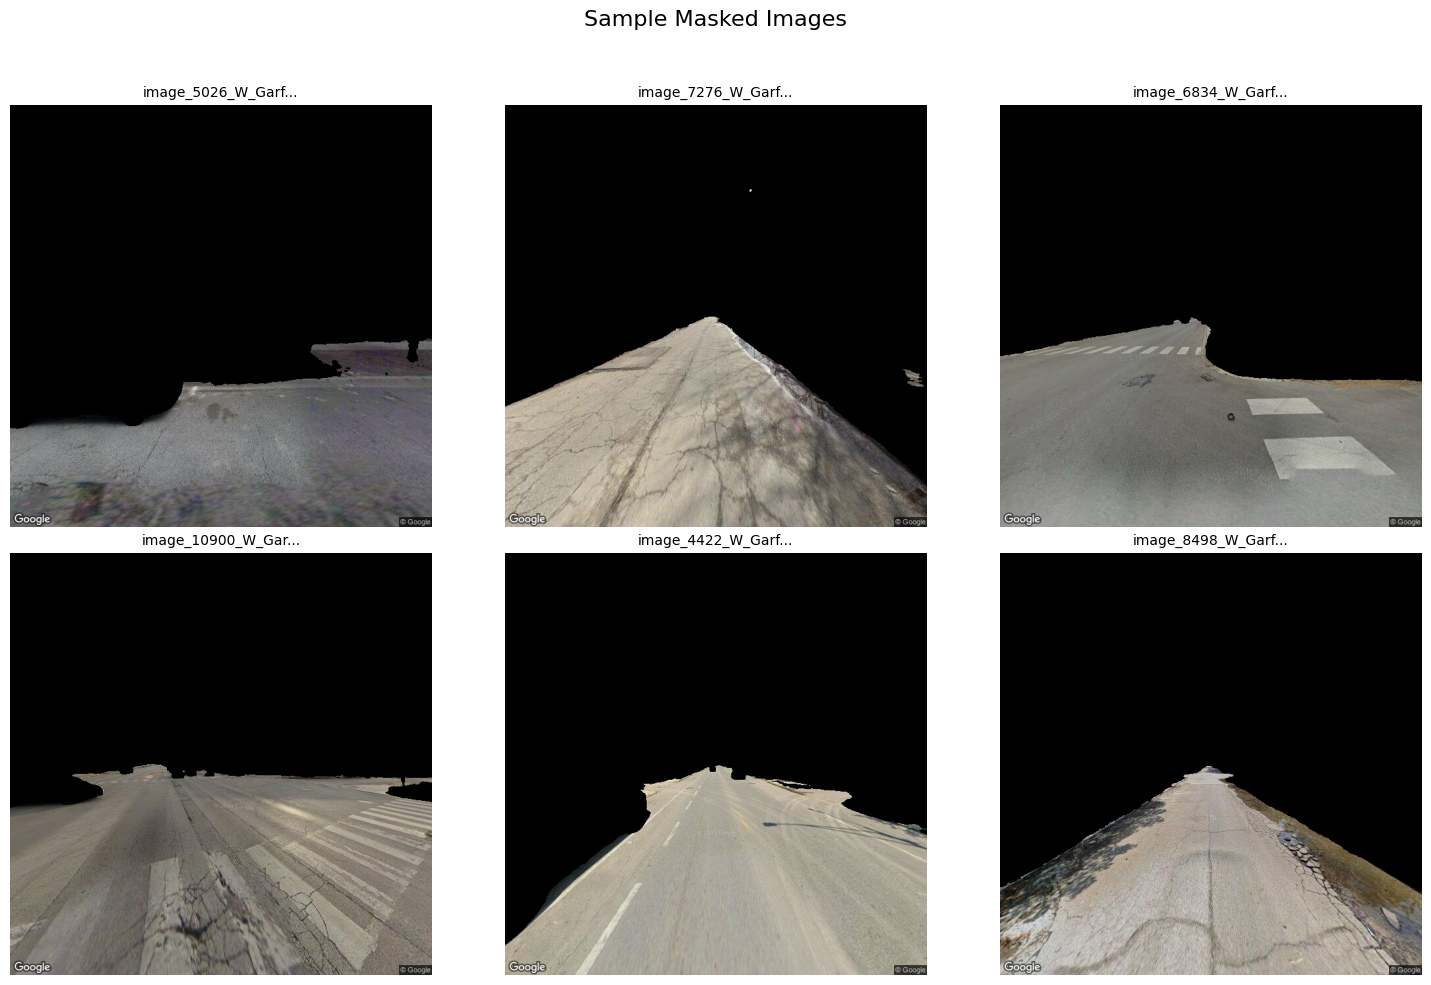

In [ ]:
# View Sample
import random
import matplotlib.pyplot as plt
from PIL import Image
image_folder = os.path.join(masked_dataset_dir, "train", "images")
image_paths = glob.glob(os.path.join(image_folder, "*.jpg"))
print(f"Found {len(image_paths)} images in {image_folder}")

# Set the random seed for reproducibility
random.seed(20)

# Randomly sample 6 images (or fewer if not enough images)
num_samples = 6
sample_paths = random.sample(image_paths, min(num_samples, len(image_paths)))

plt.figure(figsize=(15, 10))
for i, path in enumerate(sample_paths):
    img = Image.open(path).convert("RGB")
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.axis("off")

    # Get the filename and shorten it if too long
    file_name = os.path.basename(path)
    if len(file_name) > 20:
        file_name = file_name[:17] + "..."
    plt.title(file_name, fontsize=10)

plt.suptitle("Sample Masked Images", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

***
### Damage Ratio Calculation

In [ ]:
import os
import glob
import csv
import cv2
import numpy as np

In [ ]:
###OUTDATED: RUN NEXT CHUNK!

def process_dataset(masked_dataset_dir="MVP2-1_Masked"):
    """
    Iterates over train, valid, and test subsets,
    calculates the damage fraction for each image,
    and returns a list of records:
      [(image_path, damage_fraction, split), ...]
    """
    subsets = ["train", "valid", "test"]
    results = []

    for subset in subsets:
        image_dir = os.path.join(masked_dataset_dir, subset, "images")
        label_dir = os.path.join(masked_dataset_dir, subset, "labels")

        # Grab all .jpg images (adjust if you have .png)
        img_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))
        print(f"\n--- Processing {subset} set ---")
        print(f"Found {len(img_paths)} images in {image_dir}")

        for img_path in img_paths:
            # 1) Read masked image
            img = cv2.imread(img_path)  # shape (H, W, 3) in BGR
            if img is None:
                print(f"Warning: could not read {img_path}, skipping.")
                continue

            # 2) Calculate road area (non-black pixels)
            # A pixel is considered road if any channel is non-zero.
            road_mask = np.any(img != [0, 0, 0], axis=2)
            road_area = np.count_nonzero(road_mask)

            if road_area == 0:
                # Entirely black image => damage fraction = 0
                damage_fraction = 0.0
            else:
                # 3) Find label file (assumes YOLO format with .txt extension)
                base_name = os.path.splitext(os.path.basename(img_path))[0]
                label_path = os.path.join(label_dir, base_name + ".txt")

                # 4) Sum bounding box areas
                sum_box_area = 0.0
                img_h, img_w = img.shape[:2]

                if os.path.exists(label_path):
                    with open(label_path, "r") as lf:
                        lines = lf.readlines()
                        for line in lines:
                            # YOLO format: class_id x_center y_center width height (all normalized)
                            parts = line.strip().split()
                            if len(parts) != 5:
                                continue
                            class_id, x_c, y_c, w, h = parts
                            class_id = int(class_id)
                            x_c, y_c, w, h = map(float, (x_c, y_c, w, h))

                            # Process only if class_id == 0 (assuming only one class "bad road")
                            if class_id != 0:
                                continue

                            # Convert normalized dimensions to pixel values
                            box_w = w * img_w
                            box_h = h * img_h
                            box_area = box_w * box_h
                            sum_box_area += box_area
                else:
                    # If no label file, assume no bounding boxes => damage fraction = 0
                    sum_box_area = 0.0

                damage_fraction = sum_box_area / road_area

            # Save record: (image_path, damage_fraction, split)
            record = (img_path, round(damage_fraction, 4), subset)
            results.append(record)

    return results



In [ ]:
def process_dataset(masked_dataset_dir="MVP2-1_Masked"):
    """
    Iterates over train, valid, and test subsets,
    calculates the damage fraction for each image based on the
    intersection of bounding boxes with the road area,
    and returns a list of records:
      [(image_path, damage_fraction, split), ...]
    """
    subsets = ["train", "valid", "test"]
    results = []

    for subset in subsets:
        image_dir = os.path.join(masked_dataset_dir, subset, "images")
        label_dir = os.path.join(masked_dataset_dir, subset, "labels")

        # Grab all .jpg images (adjust if you have .png)
        img_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))

        print(f"\n--- Processing {subset} set ---")
        print(f"Found {len(img_paths)} images in {image_dir}")

        for img_path in img_paths:
            # 1) Read masked image
            img = cv2.imread(img_path)  # shape (H, W, 3) in BGR
            if img is None:
                print(f"Warning: could not read {img_path}, skipping.")
                continue

            # 2) Calculate road area (non-black pixels)
            # A pixel is considered road if any channel is non-zero.
            road_mask = np.any(img != [0, 0, 0], axis=2)
            road_area = np.count_nonzero(road_mask)

            if road_area == 0:
                # Entirely black image => damage fraction = 0
                damage_fraction = 0.0
            else:
                # 3) Find label file (assumes YOLO format with .txt extension)
                base_name = os.path.splitext(os.path.basename(img_path))[0]
                label_path = os.path.join(label_dir, base_name + ".txt")

                # 4) Sum intersection area of bounding boxes with road mask
                sum_box_area = 0.0
                img_h, img_w = img.shape[:2]

                if os.path.exists(label_path):
                    with open(label_path, "r") as lf:
                        lines = lf.readlines()
                        for line in lines:
                            # YOLO format: class_id x_center y_center width height (all normalized)
                            parts = line.strip().split()
                            if len(parts) != 5:
                                continue
                            class_id, x_c, y_c, w, h = parts
                            class_id = int(class_id)
                            x_c, y_c, w, h = map(float, (x_c, y_c, w, h))

                            # Process only if class_id == 0 (assuming only one class "bad road")
                            if class_id != 0:
                                continue

                            # Convert normalized values to pixel coordinates:
                            x_center = x_c * img_w
                            y_center = y_c * img_h
                            box_width = w * img_w
                            box_height = h * img_h
                            x_min = int(round(x_center - box_width/2))
                            x_max = int(round(x_center + box_width/2))
                            y_min = int(round(y_center - box_height/2))
                            y_max = int(round(y_center + box_height/2))

                            # Clip coordinates to image boundaries
                            x_min = max(0, x_min)
                            y_min = max(0, y_min)
                            x_max = min(img_w, x_max)
                            y_max = min(img_h, y_max)

                            # Compute intersection of bounding box with road_mask
                            # (i.e. count non-black pixels within the bounding box)
                            intersection_area = np.count_nonzero(road_mask[y_min:y_max, x_min:x_max])
                            sum_box_area += intersection_area
                else:
                    # If no label file, assume no bounding boxes => damage fraction = 0
                    sum_box_area = 0.0

                damage_fraction = sum_box_area / road_area

            # Save record: (image_path, damage_fraction, split)
            record = (img_path, round(damage_fraction, 4), subset)
            results.append(record)

    return results

In [ ]:
# Actually run the function
masked_dir = "MVP2-1_Masked"  # adjust if needed
data_records = process_dataset(masked_dataset_dir=masked_dir)

# data_records is now a list of tuples: (image_path, damage_fraction, split)
print("\nSample of results:")
for r in data_records[:5]:
    print(r)


--- Processing train set ---
Found 1494 images in MVP2-1_Masked/train/images

--- Processing valid set ---
Found 254 images in MVP2-1_Masked/valid/images

--- Processing test set ---
Found 255 images in MVP2-1_Masked/test/images

Sample of results:
('MVP2-1_Masked/train/images/image_10027_W_Garfield_Park_jpg.rf.15a6986ca2c49c5b62c7648afa618177.jpg', 0.0, 'train')
('MVP2-1_Masked/train/images/image_10038_W_Garfield_Park_jpg.rf.9193927bbf155a1641c9848452402497.jpg', 0.0, 'train')
('MVP2-1_Masked/train/images/image_10052_W_Garfield_Park_jpg.rf.581f5f65557cfdad907422455f90be22.jpg', 0.5078, 'train')
('MVP2-1_Masked/train/images/image_10064_W_Garfield_Park_jpg.rf.c61a5f2231e9458953ee968eb7168d08.jpg', 0.1713, 'train')
('MVP2-1_Masked/train/images/image_10101_W_Garfield_Park_jpg.rf.93df6318b8d2aaf7dcb1081e20eadfcd.jpg', 0.0, 'train')


In [ ]:
# Write to a CSV
output_csv = "damage_labels.csv"
with open(output_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["image_path", "damage_fraction", "split"])
    writer.writerows(data_records)

print(f"\nWrote {len(data_records)} records to {output_csv}.")


Wrote 2003 records to damage_labels.csv.


***
### Modeling & Results


In [ ]:
import pandas as pd

# Load the CSV containing image paths and damage fractions
df = pd.read_csv("damage_labels.csv")

# Define the threshold
threshold = 0.25  # 25%

# Create binary labels
df['binary_label'] = df['damage_fraction'].apply(lambda x: 0 if x < threshold else 1)

# Verify the distribution
print(df['binary_label'].value_counts())

binary_label
0    1422
1     581
Name: count, dtype: int64


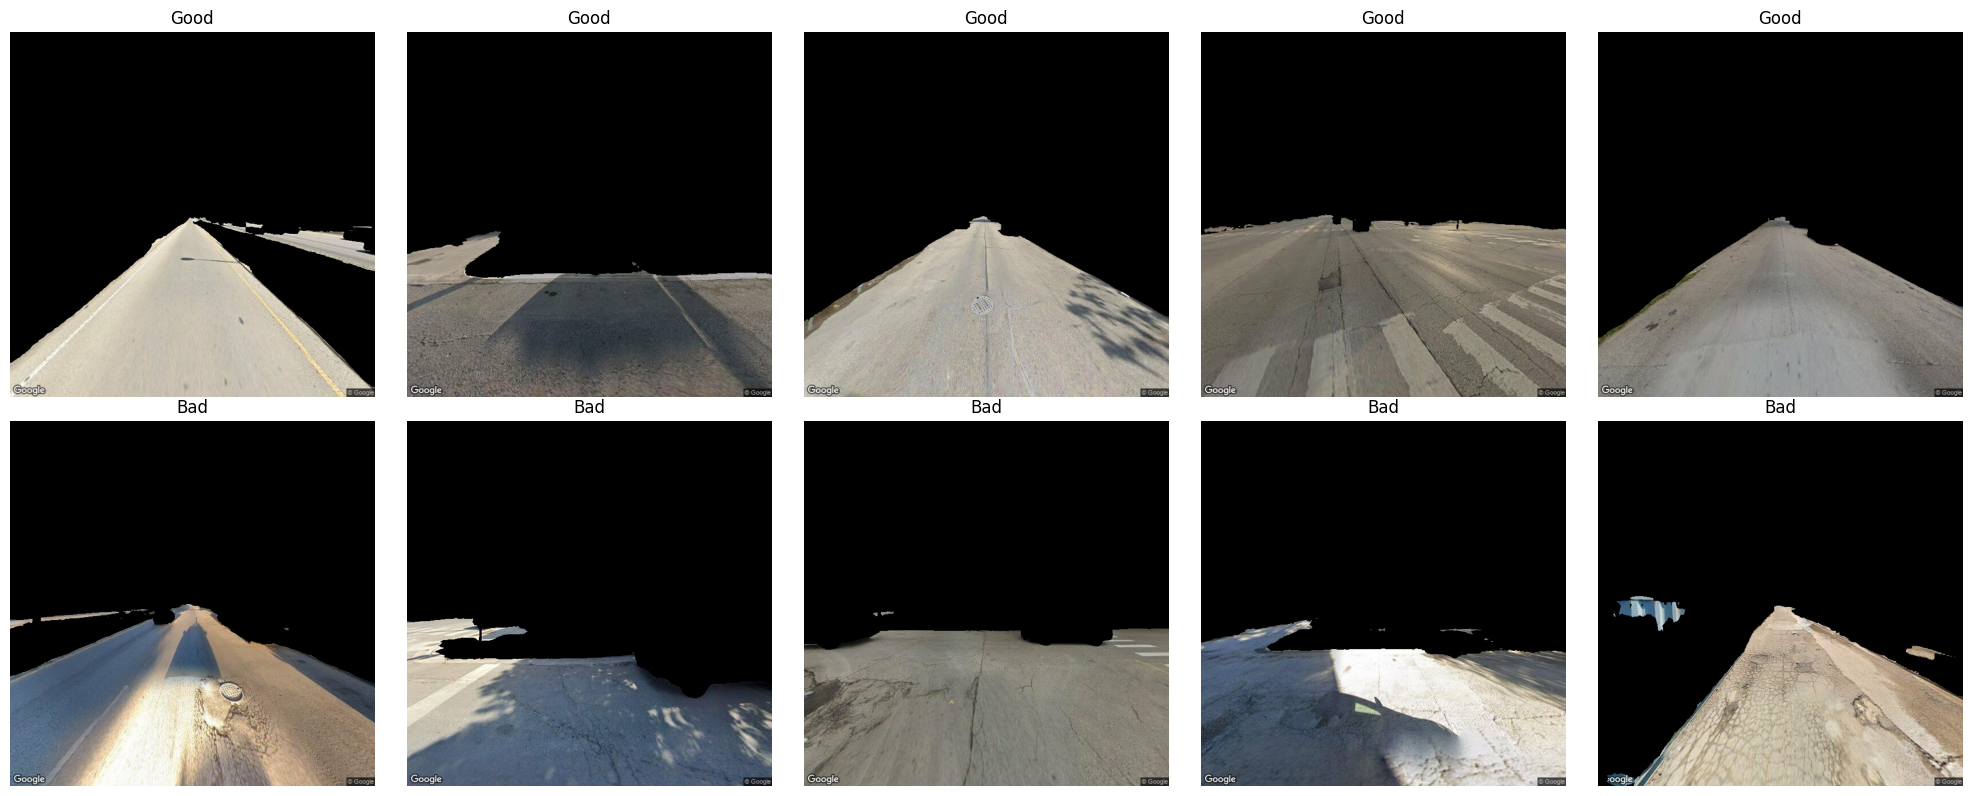

In [ ]:
# Separate the dataframe into Good (label 0) and Bad (label 1)
good_df = df[df['binary_label'] == 0]
bad_df = df[df['binary_label'] == 1]

# Sample 5 random images from each class
good_samples = good_df.sample(n=5, random_state=42)
bad_samples = bad_df.sample(n=5, random_state=42)

# Create a figure with 2 rows and 5 columns
plt.figure(figsize=(20, 8))

# Display Good images (first row)
for i, (_, row) in enumerate(good_samples.iterrows()):
    img_path = row["image_path"]
    img = Image.open(img_path).convert("RGB")
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Good", fontsize=12)

# Display Bad images (second row)
for i, (_, row) in enumerate(bad_samples.iterrows()):
    img_path = row["image_path"]
    img = Image.open(img_path).convert("RGB")
    plt.subplot(2, 5, 5 + i + 1)
    plt.imshow(img)
    plt.axis("off")
    plt.title("Bad", fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

# Create temporary bins for stratification to maintain class distribution
df['binary_label_bin'] = df['binary_label']

# Split into train and temp (validation + test)
train_df, temp_df = train_test_split(
    df,
    test_size=0.40,
    stratify=df['binary_label_bin'],
    random_state=42
)

# Split temp into validation and test
valid_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df['binary_label_bin'],
    random_state=42
)

# Drop the temporary bin column
train_df = train_df.drop(columns=['binary_label_bin'])
valid_df = valid_df.drop(columns=['binary_label_bin'])
test_df = test_df.drop(columns=['binary_label_bin'])

# Verify the splits
print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(valid_df)}")
print(f"Test samples: {len(test_df)}")

print("\nTrain class distribution:")
print(train_df['binary_label'].value_counts())

print("\nValidation class distribution:")
print(valid_df['binary_label'].value_counts())

print("\nTest class distribution:")
print(test_df['binary_label'].value_counts())


Train samples: 1201
Validation samples: 401
Test samples: 401

Train class distribution:
binary_label
0    853
1    348
Name: count, dtype: int64

Validation class distribution:
binary_label
0    284
1    117
Name: count, dtype: int64

Test class distribution:
binary_label
0    285
1    116
Name: count, dtype: int64


In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms

class RoadDatasetBinary(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.loc[idx, 'image_path']
        image = Image.open(img_path).convert("RGB")
        label = self.dataframe.loc[idx, 'binary_label']

        if self.transform:
            image = self.transform(image)

        # Convert label to float tensor for BCEWithLogitsLoss
        label = torch.tensor(label, dtype=torch.float32)

        return image, label


In [ ]:
from torchvision import transforms

# Define transformations for training and validation/testing
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

valid_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [ ]:
from torch.utils.data import DataLoader

#can try 32 as well
batch_size = 64

train_dataset = RoadDatasetBinary(train_df, transform=train_transforms)
valid_dataset = RoadDatasetBinary(valid_df, transform=valid_test_transforms)
test_dataset = RoadDatasetBinary(test_df, transform=valid_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(valid_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Train samples: 1201
Validation samples: 401
Test samples: 401


In [ ]:
import torch.nn as nn
from torchvision import models

# Load a pretrained (on ImageNet dataset) ResNet18 model or ResNet101
model = models.resnet101(pretrained=True)

# Modify the final fully connected layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # Single output for binary classification

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
import torch.nn as nn

# Define loss function
criterion = nn.BCEWithLogitsLoss()

#-----Trying weighting loss

# Compute class weights (inverse frequency method)
# num_good = df[df['binary_label'] == 0].shape[0]  # Count of good roads
# num_bad = df[df['binary_label'] == 1].shape[0]  # Count of bad roads

# class_weight = torch.tensor([num_good / num_bad]).to(device)  # More weight to bad roads

# # Define weighted loss function
# criterion = nn.BCEWithLogitsLoss(pos_weight=class_weight)  # ✅ Update here

#----

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Define learning rate scheduler (optional)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [ ]:
num_epochs = 50
best_val_acc = 0.0
patience = 20
trigger_times = 0

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    # Training Phase
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).unsqueeze(1)  # Shape: (batch_size, 1)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Calculate predictions
        preds = torch.sigmoid(outputs)
        preds = (preds > 0.5).float()
        correct_preds += torch.sum(preds == labels)
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct_preds.double() / total

    print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    # Validation Phase
    model.eval()
    val_running_loss = 0.0
    val_correct_preds = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)

            # Calculate predictions
            preds = torch.sigmoid(outputs)
            preds = (preds > 0.5).float()
            val_correct_preds += torch.sum(preds == labels)
            val_total += labels.size(0)

    val_loss = val_running_loss / val_total
    val_acc = val_correct_preds.double() / val_total

    print(f'Valid Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    # Step the scheduler
    scheduler.step()

    # Early Stopping Check
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model_binary.pth')
        print("Saved Best Model")
    else:
        trigger_times += 1
        print(f'EarlyStopping counter: {trigger_times} out of {patience}')
        if trigger_times >= patience:
            print("Early stopping!")
            break

    print()


Epoch 1/50
----------
Train Loss: 0.5130 Acc: 0.7544
Valid Loss: 0.4965 Acc: 0.7781
Saved Best Model

Epoch 2/50
----------
Train Loss: 0.3803 Acc: 0.8285
Valid Loss: 0.4720 Acc: 0.8005
Saved Best Model

Epoch 3/50
----------
Train Loss: 0.3443 Acc: 0.8401
Valid Loss: 0.4414 Acc: 0.8080
Saved Best Model

Epoch 4/50
----------
Train Loss: 0.3323 Acc: 0.8518
Valid Loss: 0.3908 Acc: 0.8354
Saved Best Model

Epoch 5/50
----------
Train Loss: 0.2860 Acc: 0.8801
Valid Loss: 0.3561 Acc: 0.8379
Saved Best Model

Epoch 6/50
----------
Train Loss: 0.2487 Acc: 0.8984
Valid Loss: 0.3813 Acc: 0.8554
Saved Best Model

Epoch 7/50
----------
Train Loss: 0.2286 Acc: 0.8951
Valid Loss: 0.4213 Acc: 0.8304
EarlyStopping counter: 1 out of 20

Epoch 8/50
----------
Train Loss: 0.2246 Acc: 0.9034
Valid Loss: 0.3532 Acc: 0.8529
EarlyStopping counter: 2 out of 20

Epoch 9/50
----------
Train Loss: 0.2232 Acc: 0.9001
Valid Loss: 0.3413 Acc: 0.8653
Saved Best Model

Epoch 10/50
----------
Train Loss: 0.1960 Acc:

In [ ]:
# Load the best model weights
model.load_state_dict(torch.load('best_model_binary.pth'))
model = model.to(device)
model.eval()


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Classification Report:
              precision    recall  f1-score   support

        Good       0.89      0.82      0.86       285
         Bad       0.64      0.76      0.69       116

    accuracy                           0.81       401
   macro avg       0.77      0.79      0.78       401
weighted avg       0.82      0.81      0.81       401



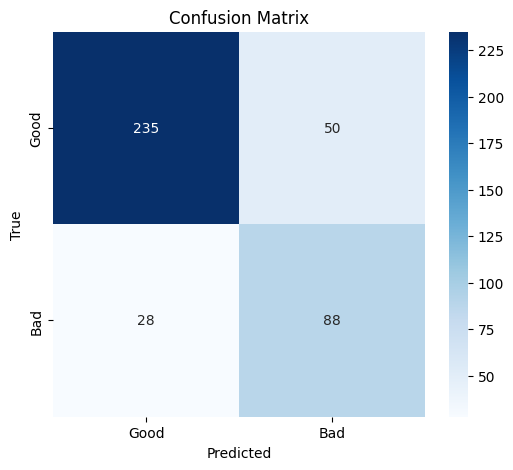

Test ROC-AUC: 0.8885


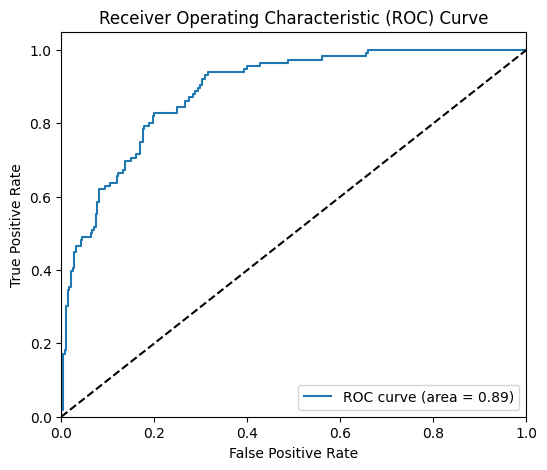

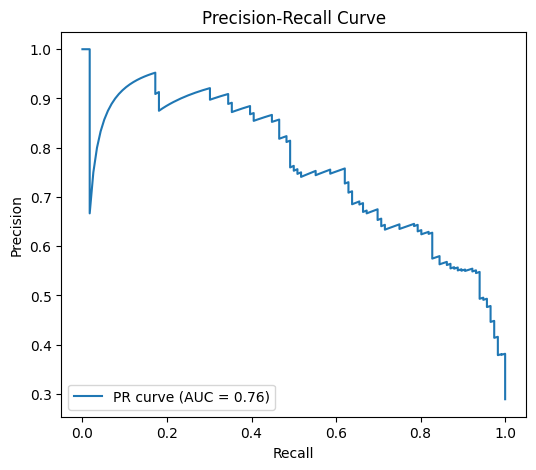

Test ROC-AUC: 0.8885
Test PR-AUC: 0.7593


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def get_predictions_binary(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)

            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.4).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

# Get predictions on the test set
test_preds, test_labels, test_probs = get_predictions_binary(model, test_loader, device)

# Classification Report
print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=["Good", "Bad"]))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Good", "Bad"],
            yticklabels=["Good", "Bad"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC-AUC
roc_auc = roc_auc_score(test_labels, test_probs)
print(f"Test ROC-AUC: {roc_auc:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(test_labels, test_probs)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(test_labels, test_probs)
pr_auc = auc(recall, precision)  # Compute AUC for PR curve

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

print(f"Test ROC-AUC: {roc_auc:.4f}")
print(f"Test PR-AUC: {pr_auc:.4f}")


*Save results and evaluation artifacts to drive*

In [ ]:
import datetime
# -------------------------------
# 1. Mount Google Drive and Create Folder Structure
# -------------------------------
from google.colab import drive
drive.mount('/content/drive')

# Parent folder for saving models/evaluation artifacts
parent_dir = "/content/drive/MyDrive/Road_Damage_Models"
os.makedirs(parent_dir, exist_ok=True)

# Create a new subfolder with a timestamp
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_folder = f"best_model_binary_{timestamp}"
target_dir = os.path.join(parent_dir, model_folder)
os.makedirs(target_dir, exist_ok=True)
print(f"Created folder: {target_dir}")

# -------------------------------
# 2. Save the Best Model Weights
# -------------------------------
# (Assuming your model is already loaded with the best weights)
torch.save(model.state_dict(), os.path.join(target_dir, "best_model_binary.pth"))
print("Saved model weights.")

# -------------------------------
# 3. Define Helper Function to Get Predictions (Without Paths)
# -------------------------------
def get_predictions_binary(model, dataloader, device):
    """
    Iterates over the dataloader and returns:
      - all_preds: predicted labels (0 or 1)
      - all_labels: true labels
      - all_probs: predicted probabilities (float between 0 and 1)
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)  # shape (batch, 1)
            outputs = model(inputs)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).float()

            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
            all_probs.extend(probs.cpu().numpy().flatten())

    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

# -------------------------------
# 4. Get Predictions on the Test Set
# -------------------------------
# Make sure your test_loader is defined and your dataset returns (image, label)
test_preds, test_labels, test_probs = get_predictions_binary(model, test_loader, device)
print(f"Test predictions: {len(test_preds)} samples.")

# -------------------------------
# 5. Save Evaluation Artifacts
# -------------------------------

# -- Confusion Matrix --
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Good", "Bad"],
            yticklabels=["Good", "Bad"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
cm_path = os.path.join(target_dir, "confusion_matrix.png")
plt.savefig(cm_path)
plt.close()
print("Saved confusion matrix plot.")

# -- Classification Report --
report = classification_report(test_labels, test_preds, target_names=["Good", "Bad"])
report_path = os.path.join(target_dir, "classification_report.txt")
with open(report_path, "w") as f:
    f.write(report)
print("Saved classification report.")

# -- ROC Curve --
roc_auc = roc_auc_score(test_labels, test_probs)
fpr, tpr, thresholds = roc_curve(test_labels, test_probs)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
roc_path = os.path.join(target_dir, "roc_curve.png")
plt.savefig(roc_path)
plt.close()
print("Saved ROC curve plot.")

# -- Precision-Recall Curve --
precision, recall, pr_thresholds = precision_recall_curve(test_labels, test_probs)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.2f})', color="blue")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
pr_path = os.path.join(target_dir, "pr_curve.png")
plt.savefig(pr_path)
plt.close()
print("Saved Precision-Recall curve plot.")

print(f"All model artifacts and evaluation metrics have been saved in: {target_dir}")

Mounted at /content/drive
Created folder: /content/drive/MyDrive/Road_Damage_Models/best_model_binary_20250227_052925
Saved model weights.
Test predictions: 401 samples.
Saved confusion matrix plot.
Saved classification report.
Saved ROC curve plot.
Saved Precision-Recall curve plot.
All model artifacts and evaluation metrics have been saved in: /content/drive/MyDrive/Road_Damage_Models/best_model_binary_20250227_052925


In [ ]:
# ----------------------
# 5️⃣ Plot Metrics
# ----------------------
# Plot the updated presentation-ready Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.fill_between(recall, precision, alpha=0.3, color='orange', label='Area Under Curve (AUC)')
plt.plot(recall, precision, color='darkorange', linewidth=2.5, label=f'Average Precision = {avg_precision:.2f}')
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=16, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(False)  # Remove gridlines for a cleaner presentation look
plt.show()




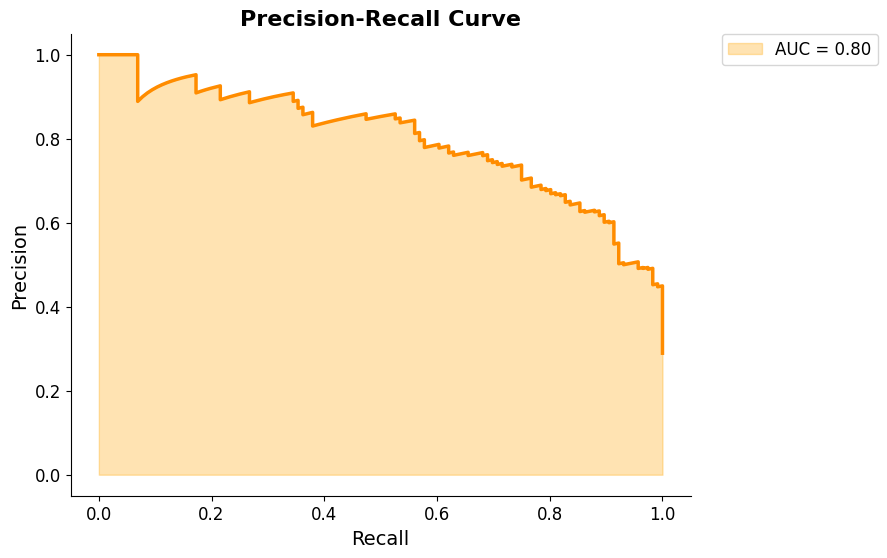

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Compute Precision-Recall Curve
precision, recall, pr_thresholds = precision_recall_curve(test_labels, test_probs)
pr_auc = auc(recall, precision)  # Compute AUC for PR curve

# Plot the updated presentation-ready Precision-Recall Curve
plt.figure(figsize=(8, 6))

# Fill under the curve for better visualization
plt.fill_between(recall, precision, alpha=0.3, color='orange', label=f'AUC = {pr_auc:.2f}')

# Plot the PR curve with smooth styling
plt.plot(recall, precision, color='darkorange', linewidth=2.5)

# Formatting and Styling
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curve', fontsize=16, weight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

# Clean Presentation Look
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(False)  # Remove gridlines for a cleaner presentation look

# Show the final plot
plt.show()


***
### Auditing


In [ ]:
###To do: Run inference on new neighborhood images and visually inspect predictions; Run GradCAM or similar to see where model used

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load Model

best_model_binary_20250216_052705

In [ ]:
import torch
try:
    import torch._dynamo as dynamo
    dynamo.disable()  # disable TorchDynamo to bypass its configuration issues
except ImportError:
    pass  # torch._dynamo might not exist in older versions of torch


In [ ]:
#!pip install --upgrade torch torchvision

  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
  Attempting uninstall: sympy
    Found existing installation: sympy 1.8
    Uninstalling sympy-1.8:
      Successfully uninstalled sympy-1.8
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.18 requires torch<2.6,>=1.10, but you have torch 2.6.0 which is incompatible.
torchaudio 2.5.1+cu124 requires torch==2.5.1, but you have torch 2.6.0 which is incompatible.


In [ ]:
import torch
print(torch.__version__)

2.6.0+cu124


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Use a pretrained ResNet101, then modify the final layer for 1 output.
model = models.resnet101(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # 1 output, matching your checkpoint

model_path = '/content/drive/My Drive/Road_Damage_Models/best_model_binary_20250216_052705/best_model_binary.pth'
model.load_state_dict(torch.load(model_path, map_location=torch.device('cuda')))
model = model.to('cuda')
model.eval()

print("Model loaded successfully!")


Model loaded successfully!


In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39648 sha256=b5b9df2a6f7ad2fac230173ead2985791e396f575e2a8cef89526c8bfd3d7a9e
  Stored in directory: /root/.cache/pip/wheels/8b/0d/d2/b12bec1ccc028921fb98158042ade2d19dae73925dfc636954
Successfully built grad-cam


In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image
import cv2
import numpy as np


In [ ]:
target_layer = model.layer4[-1].conv3

In [ ]:
from torchvision import transforms
from PIL import Image
import random, os

In [ ]:
# Instantiate GradCAM with the model and target layer.
cam = GradCAM(model=model, target_layers=[target_layer])

In [ ]:
# Preprocessing function (adjust size/normalization as used in training).
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # adjust as needed
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
# Example: load a random image from a folder.
test_images_folder = '/content/drive/My Drive/RDD2022_US_Masked/train/img'
all_images = [os.path.join(test_images_folder, fname) for fname in os.listdir(test_images_folder) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]
sample_image_path = random.choice(all_images)

In [ ]:
pil_img = Image.open(sample_image_path).convert('RGB')
img_tensor = preprocess(pil_img).unsqueeze(0).to('cuda')

# Generate GradCAM heatmap.
grayscale_cam = cam(input_tensor=img_tensor, targets=None)  # `None` will use the predicted class
grayscale_cam = grayscale_cam[0, :]

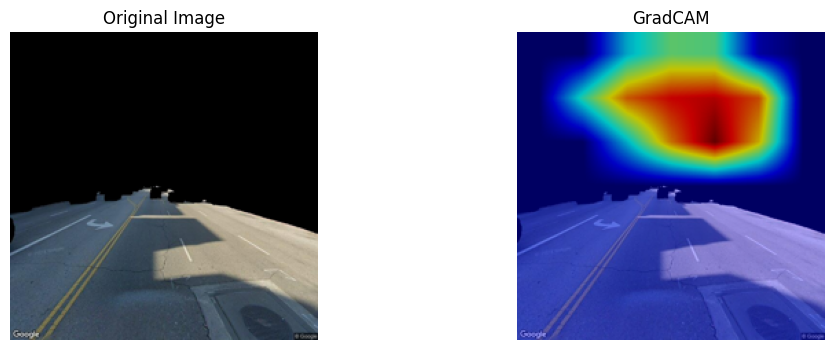

In [ ]:
# Convert PIL image to numpy array and resize.
rgb_img = np.array(pil_img.resize((224, 224))) / 255.0
visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

# Display the result.
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(rgb_img)
plt.title("Original Image")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(visualization)
plt.title("GradCAM")
plt.axis('off')
plt.show()

'/content/drive/My Drive/RDD2022_US_Masked/train/img'

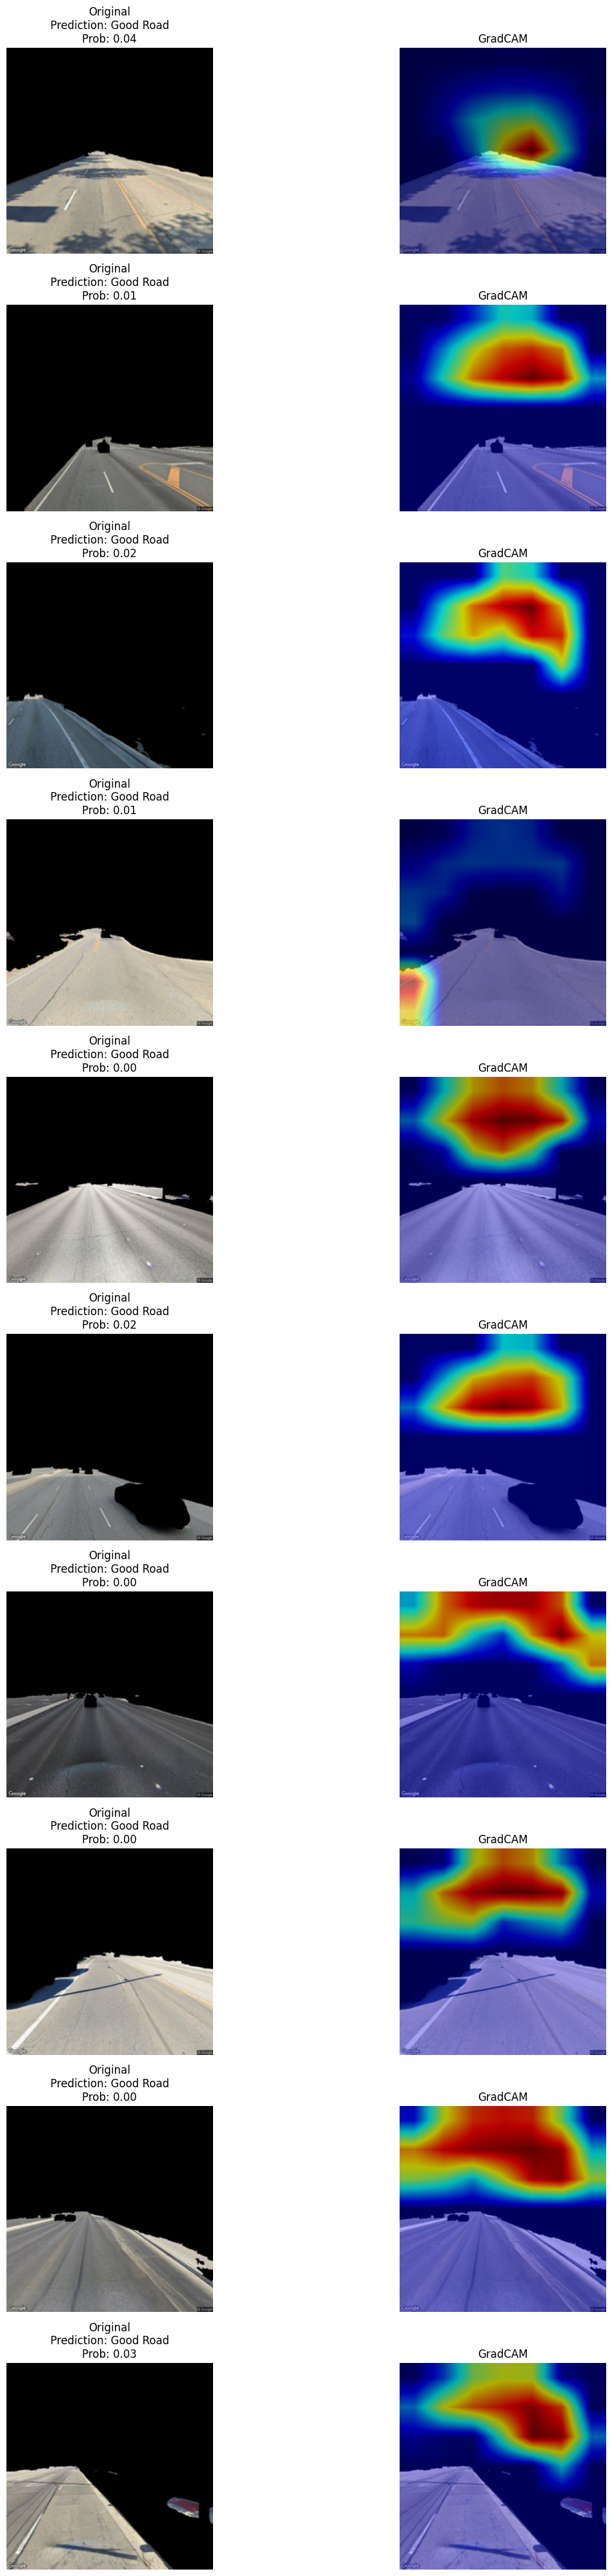

In [ ]:
# Folder containing test images
test_images_folder = '/content/drive/My Drive/RDD2022_US_Masked/train/img'
all_images = [os.path.join(test_images_folder, fname)
              for fname in os.listdir(test_images_folder)
              if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Select 10 random images
sample_images = random.sample(all_images, 10)

# Preprocessing transform (adjust based on your training)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Select the target layer for GradCAM (last conv layer in ResNet101)
target_layer = model.layer4[-1].conv3

# Instantiate GradCAM (without use_cuda, assuming model & inputs are on GPU)
cam = GradCAM(model=model, target_layers=[target_layer])

# Create a figure to show all images (2 columns per image: Original with prediction and GradCAM overlay)
plt.figure(figsize=(15, 40))

for idx, img_path in enumerate(sample_images):
    # Load image and preprocess
    pil_img = Image.open(img_path).convert('RGB')
    img_tensor = preprocess(pil_img).unsqueeze(0).to('cuda')

    # Model prediction
    with torch.no_grad():
        output = model(img_tensor)
        # Apply sigmoid to get probability; adjust threshold as needed.
        prob = torch.sigmoid(output).item()
        label = "Bad Road" if prob > 0.5 else "Good Road"

    # Compute GradCAM heatmap
    grayscale_cam = cam(input_tensor=img_tensor, targets=None)
    grayscale_cam = grayscale_cam[0, :]

    # Prepare original image for overlay (resize and scale to [0, 1])
    rgb_img = np.array(pil_img.resize((224, 224))) / 255.0
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Plot original image with prediction text
    plt.subplot(10, 2, idx*2+1)
    plt.imshow(rgb_img)
    plt.title(f"Original\nPrediction: {label}\nProb: {prob:.2f}")
    plt.axis('off')

    # Plot GradCAM overlay
    plt.subplot(10, 2, idx*2+2)
    plt.imshow(visualization)
    plt.title("GradCAM")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Folder containing test images
test_images_folder = '/content/drive/My Drive/RDD2022_US_Masked/train/img'
all_images = [os.path.join(test_images_folder, fname)
              for fname in os.listdir(test_images_folder)
              if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Preprocessing transform (adjust as used in training)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Select the target layer for GradCAM (last conv layer in ResNet101)
target_layer = model.layer4[-1].conv3
# Instantiate GradCAM (no use_cuda argument needed if model & tensors are on GPU)
cam = GradCAM(model=model, target_layers=[target_layer])

# Container for bad road images (prediction prob > 0.5)
bad_images = []  # Will store tuples: (img_path, probability, gradcam visualization, original resized image)

# Loop through images and collect those predicted as bad roads
for img_path in all_images:
    pil_img = Image.open(img_path).convert('RGB')
    img_tensor = preprocess(pil_img).unsqueeze(0).to('cuda')

    # Get model prediction
    with torch.no_grad():
        output = model(img_tensor)
        # Since model outputs one logit, apply sigmoid to get probability for "Bad Road"
        prob = torch.sigmoid(output).item()

    # If probability is greater than 0.5, it's predicted as a bad road.
    if prob > 0.5:
        # Compute GradCAM heatmap
        grayscale_cam = cam(input_tensor=img_tensor, targets=None)
        grayscale_cam = grayscale_cam[0, :]

        # Prepare original image for overlay: resize to 224x224 and normalize to [0,1]
        rgb_img = np.array(pil_img.resize((224, 224))) / 255.0
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        bad_images.append((img_path, prob, visualization, rgb_img))

        # Stop when we have found 10 bad road images
        if len(bad_images) >= 10:
            break

if len(bad_images) == 0:
    print("No bad road images were found.")
else:
    # Display the 10 bad road images with GradCAM overlays and prediction probabilities.
    plt.figure(figsize=(15, 40))
    for idx, (img_path, prob, visualization, rgb_img) in enumerate(bad_images):
        plt.subplot(10, 2, idx*2+1)
        plt.imshow(rgb_img)
        plt.title(f"Original\nProb: {prob:.2f}")
        plt.axis('off')

        plt.subplot(10, 2, idx*2+2)
        plt.imshow(visualization)
        plt.title("GradCAM")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Folder containing test images
test_images_folder = '/content/drive/My Drive/RDD2022_US_Masked/train/img'
all_images = [os.path.join(test_images_folder, fname)
              for fname in os.listdir(test_images_folder)
              if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Preprocessing transform (adjust as used in training)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Select the target layer for GradCAM (last conv layer in ResNet101)
target_layer = model.layer4[-1].conv3
# Instantiate GradCAM (no use_cuda argument needed if model & tensors are on GPU)
cam = GradCAM(model=model, target_layers=[target_layer])

# Container for bad road images (prediction prob > 0.5)
bad_images = []  # Will store tuples: (img_path, probability, gradcam visualization, original resized image)

# Loop through images and collect those predicted as bad roads
for img_path in all_images:
    pil_img = Image.open(img_path).convert('RGB')
    img_tensor = preprocess(pil_img).unsqueeze(0).to('cuda')

    # Get model prediction
    with torch.no_grad():
        output = model(img_tensor)
        # Since model outputs one logit, apply sigmoid to get probability for "Bad Road"
        prob = torch.sigmoid(output).item()

    # If probability is greater than 0.5, it's predicted as a bad road.
    if prob > 0.5:
        # Compute GradCAM heatmap
        grayscale_cam = cam(input_tensor=img_tensor, targets=None)
        grayscale_cam = grayscale_cam[0, :]

        # Prepare original image for overlay: resize to 224x224 and normalize to [0,1]
        rgb_img = np.array(pil_img.resize((224, 224))) / 255.0
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        bad_images.append((img_path, prob, visualization, rgb_img))

        # Stop when we have found 20 bad road images
        if len(bad_images) >= 20:
            break

if len(bad_images) == 0:
    print("No bad road images were found.")
else:
    # Display the 20 bad road images with GradCAM overlays and prediction probabilities.
    plt.figure(figsize=(15, 80))  # Adjust the figure size as needed
    for idx, (img_path, prob, visualization, rgb_img) in enumerate(bad_images):
        plt.subplot(20, 2, idx*2+1)
        plt.imshow(rgb_img)
        plt.title(f"Original\nProb: {prob:.2f}")
        plt.axis('off')

        plt.subplot(20, 2, idx*2+2)
        plt.imshow(visualization)
        plt.title("GradCAM")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

***
### Heatmap


In [ ]:
###To do: Once model is determined acceptible, run inference on all images available in each neighborhood; Determine bad road concentration